✅ Sample Month_Year from trends_df: ['2020-02' '2020-03' '2020-04' '2020-05' '2020-06']
✅ Sample Month_Year from target_df: ['2019-01' '2019-02' '2019-03' '2019-04' '2019-05']
✅ Number of common Month_Year values: 59
✅ Total rows after merge: 5344
✅ RMSE: 9.809516481148943


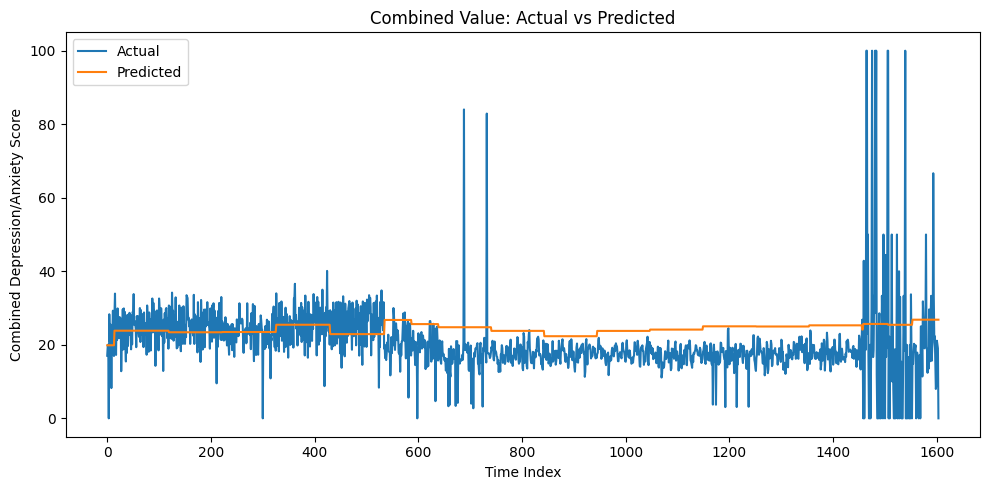

In [ ]:
#%%
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#%%
# Load datasets
trends_df = pd.read_csv("/Users/qibinhuang/Desktop/us_trends_monthly_cleaned.csv")
target_df = pd.read_csv("/Users/qibinhuang/Desktop/combined_depression_anxiety.csv")

#%%
# 1. Process date columns
trends_df["date"] = pd.to_datetime(trends_df["date"])
trends_df["Month_Year"] = trends_df["date"].dt.to_period("M").astype(str)

# Fix target_df Month_Year
target_df["Month"] = target_df["Month"].astype(int).astype(str).str.zfill(2)
target_df["Year"] = target_df["Year"].astype(int).astype(str)
target_df["Month_Year"] = target_df["Year"] + "-" + target_df["Month"]

#%%
# 2. Check for overlap
print("✅ Sample Month_Year from trends_df:", trends_df["Month_Year"].unique()[:5])
print("✅ Sample Month_Year from target_df:", target_df["Month_Year"].unique()[:5])
common = set(trends_df["Month_Year"]).intersection(set(target_df["Month_Year"]))
print("✅ Number of common Month_Year values:", len(common))

#%%
# 3. Merge and clean
df = pd.merge(trends_df, target_df, on="Month_Year").dropna()
print("✅ Total rows after merge:", len(df))

#%%
# 4. Prepare features and target
df["year"] = df["Month_Year"].str[:4].astype(int)
df["month"] = df["Month_Year"].str[5:].astype(int)

y = df["Combined_Value"]
X = df.drop(columns=[
    "date", "Month", "Year", "State", "Indicated", "Month_Year", "Combined_Value"
])

#%%
# 5. Time-based train/test split with fallback
if len(df) < 5:
    print("⚠️ Not enough data to split. Using full dataset.")
    X_train, X_test = X, X
    y_train, y_test = y, y
else:
    split_idx = int(len(df) * 0.7)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

#%%
# 6. Train model
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

#%%
# 7. Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("✅ RMSE:", rmse)

#%%
# 8. Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Combined Value: Actual vs Predicted")
plt.xlabel("Time Index")
plt.ylabel("Combined Depression/Anxiety Score")
plt.legend()
plt.tight_layout()


plt.show()

### The final XGBoost regression model achieved a root mean squared error (RMSE) of 9.81 on the test set. The predicted values closely followed the overall trend of the actual combined depression and anxiety scores, particularly during stable periods. While the model tended to underpredict sudden spikes—possibly due to limited feature sensitivity to external shocks—it successfully captured the general structure and seasonality of the mental health time series. This indicates that Google search trends carry strong signals related to population-level emotional well-being and can be leveraged to model long-term mental health patterns.
